<a href="https://colab.research.google.com/github/zongming03/Feature-Engineering/blob/main/IndividualAssignment_WIE3007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install featuretools
!pip install google-cloud-pubsub

In [3]:
!pip install google-cloud-pubsub
import featuretools as ft
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

##Setup Google Cloud Pub/Sub

In [6]:
from google.cloud import pubsub_v1

# Setup Google Cloud Pub/Sub
project_id = "wie3007ia"
customer_topic_id = "customer-updates"
order_topic_id = "order-updates"

# Initialize Publisher Client
publisher = pubsub_v1.PublisherClient()

# Create Pub/Sub topics
def create_topic(topic_id):
    topic_path = publisher.topic_path(project_id, topic_id)
    try:
        topic = publisher.create_topic(request={"name": topic_path})
        print(f"Created topic: {topic.name}")
    except Exception as e:
        print(f"Topic already exists: {e}")

create_topic(customer_topic_id)
create_topic(order_topic_id)


ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7cb4f6f681f0>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

Topic already exists: 504 Deadline Exceeded


ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7cb4f6f681f0>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

Topic already exists: 504 Deadline Exceeded


##Load Dataset

In [7]:
# Create DataFrames for customers, products, orders, and order details

# Load data from Excel
file_path = '/content/Book1.xlsx'
customers_df = pd.read_excel(file_path, sheet_name='Customers')
products_df = pd.read_excel(file_path, sheet_name='Products')
orders_df = pd.read_excel(file_path, sheet_name='Orders')
order_details_df = pd.read_excel(file_path, sheet_name='OrderDetails')

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7cb4f6f681f0>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

###Convert to datetime

In [8]:
# Convert to datetime
# Convert to datetime with day-first format
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], dayfirst=True)
orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'], dayfirst=True)
orders_df['ShipDate'] = pd.to_datetime(orders_df['ShipDate'], dayfirst=True)

##Pub/Sub Listener Setup

In [9]:
from google.cloud import pubsub_v1
import json

# Initialize Subscriber Client
subscriber = pubsub_v1.SubscriberClient()

# Subscription paths
customer_subscription_path = subscriber.subscription_path(project_id, 'customer-updates-sub')
order_subscription_path = subscriber.subscription_path(project_id, 'order-updates-sub')

# Callback functions
def customer_callback(message):
    global customers_df
    data = json.loads(message.data.decode('utf-8'))
    customer_update = pd.DataFrame([data])
    customers_df = pd.concat([customers_df, customer_update]).drop_duplicates(subset='CustomerID', keep='last')
    message.ack()
    print("Customer Data Updated")

def order_callback(message):
    global orders_df
    data = json.loads(message.data.decode('utf-8'))
    order_update = pd.DataFrame([data])
    orders_df = pd.concat([orders_df, order_update]).drop_duplicates(subset='OrderID', keep='last')
    message.ack()
    print("Order Data Updated")

# Start listening for updates
subscriber.subscribe(customer_subscription_path, callback=customer_callback)
subscriber.subscribe(order_subscription_path, callback=order_callback)
print("Listening for Pub/Sub updates...")


Listening for Pub/Sub updates...


###Add Combined key in the order details

To add order details a unique key

In [10]:
# Add a combined key in the order details
order_details_df['OrderDetailsID'] = order_details_df['OrderID'].astype(str) + '_' + order_details_df['ProductID'].astype(str)

In [11]:
display(customers_df)
display(products_df)
display(orders_df)
display(order_details_df)

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7cb5082b1d80>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

,CustomerID,Name,Email,SignupDate
0,101,John Doe,john.doe@example.com,2023-01-10
1,102,Jane Smith,jane.smith@example.com,2023-01-15
2,103,Mike Jordan,mike.jordan@example.com,2023-01-20
3,104,Emma Stone,emma.stone@example.com,2023-02-01
4,105,Chris Evans,chris.evans@example.com,2023-02-05
5,106,Alice Brown,alice.brown@example.com,2023-02-10
6,107,Bob Johnson,bob.johnson@example.com,2023-02-15
7,108,Charlie Davis,charlie.davis@example.com,2023-02-20
8,109,David Garcia,david.garcia@example.com,2023-03-01
9,110,Emily Wilson,emily.wilson@example.com,2023-03-05


,ProductID,Name,Category,Price
0,201,Laptop,Electronics,1000
1,202,Tablet,Electronics,500
2,203,Smartphone,Electronics,800
3,204,Headphones,Accessories,200
4,205,Smartwatch,Electronics,300
5,206,Mouse,Accessories,50
6,207,Keyboard,Accessories,100
7,208,Monitor,Electronics,300
8,209,Printer,Electronics,250
9,210,Webcam,Accessories,150


ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7cb5082b1d80>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

,OrderID,CustomerID,OrderDate,ShipDate
0,301,101,2023-02-01,2023-02-03
1,302,102,2023-02-05,2023-02-07
2,303,103,2023-02-10,2023-02-12
3,304,104,2023-02-12,2023-02-14
4,305,105,2023-02-15,2023-02-17
5,306,106,2023-02-20,2023-02-22
6,307,107,2023-02-22,2023-02-25
7,308,108,2023-03-01,2023-03-03
8,309,109,2023-03-05,2023-03-07
9,310,110,2023-03-10,2023-03-12


,OrderID,ProductID,Quantity,Discount,OrderDetailsID
0,301,201,2,0.00,301_201
1,302,202,10,0.10,302_202
2,303,203,1,0.00,303_203
3,304,204,32,0.00,304_204
4,305,205,1,0.00,305_205
...,...,...,...,...,...
98,358,202,16,0.06,358_202
99,359,203,13,0.00,359_203
100,359,209,15,0.05,359_209
101,359,207,15,0.00,359_207


###Check Missing Value in dataset

In [12]:
# Check for missing values in each DataFrame
print(customers_df.isnull().sum())
print(products_df.isnull().sum())
print(orders_df.isnull().sum())
print(order_details_df.isnull().sum())


ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7cb5082b1d80>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

CustomerID    0
Name          0
Email         0
SignupDate    0
dtype: int64
ProductID    0
Name         0
Category     0
Price        0
dtype: int64
OrderID       0
CustomerID    0
OrderDate     0
ShipDate      0
dtype: int64
OrderID           0
ProductID         0
Quantity          0
Discount          0
OrderDetailsID    0
dtype: int64


###Drop Duplicate Data if exist

In [13]:
customers_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
orders_df.drop_duplicates(inplace=True)
order_details_df.drop_duplicates(inplace=True)

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7cb5082b1d80>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

### Update the original order_details_df with TotalPrice


In [14]:
# Merge order_details with products to get price
merged_order_details = order_details_df.merge(products_df[['ProductID', 'Price']], on='ProductID')

# Calculate TotalPrice and add it to the merged DataFrame
merged_order_details['TotalPrice'] = merged_order_details['Price'] * merged_order_details['Quantity']

# Update the original order_details_df with TotalPrice
order_details_df['TotalPrice'] = merged_order_details['TotalPrice']
print(order_details_df)

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7cb5082b1d80>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

     OrderID  ProductID  Quantity  Discount OrderDetailsID  TotalPrice
0        301        201         2      0.00        301_201        2000
1        302        202        10      0.10        302_202        5000
2        303        203         1      0.00        303_203         800
3        304        204        32      0.00        304_204        6400
4        305        205         1      0.00        305_205         300
..       ...        ...       ...       ...            ...         ...
98       358        202        16      0.06        358_202        8000
99       359        203        13      0.00        359_203       10400
100      359        209        15      0.05        359_209        3750
101      359        207        15      0.00        359_207        1500
102      360        208        37      0.13        360_208       11100

[103 rows x 6 columns]


ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7cb5082b1d80>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

## Entity Set

In [28]:
# creating entity set 'entitySet'
entitySet = ft.EntitySet(id="e-commerce_es")

#Add DataFrame to the EntitySet
#Customers
customers_entity = entitySet.add_dataframe(
    dataframe=customers_df,  #  Dataframe containing the data.
    dataframe_name='Customers',  # Unique name to associate with this dataframe
    index='CustomerID',  # Unique identifier
    time_index='SignupDate'
)

#Products
products_entity = entitySet.add_dataframe(
    dataframe=products_df,
    dataframe_name='Products',
    index='ProductID'
)

#Orders
orders_entity = entitySet.add_dataframe(
    dataframe=orders_df,
    dataframe_name='Orders',
    index='OrderID' ,
    time_index='OrderDate',
)

#OrdersDetails
orderDetails_entity = entitySet.add_dataframe(
    dataframe=order_details_df,
    dataframe_name='OrderDetails',
    index='OrderDetailsID'
)

In [29]:
print(entitySet)

Entityset: e-commerce_es
  DataFrames:
    Customers [Rows: 10, Columns: 4]
    Products [Rows: 10, Columns: 4]
    Orders [Rows: 60, Columns: 4]
    OrderDetails [Rows: 103, Columns: 6]
  Relationships:
    No relationships


####Establish relationship

In [30]:
# Define relationships
entitySet.add_relationship(parent_dataframe_name='Customers', parent_column_name='CustomerID',
                    child_dataframe_name='Orders', child_column_name='CustomerID')

entitySet.add_relationship(parent_dataframe_name='Products', parent_column_name='ProductID',
                    child_dataframe_name='OrderDetails', child_column_name='ProductID')

entitySet.add_relationship(parent_dataframe_name='Orders', parent_column_name='OrderID',
                    child_dataframe_name='OrderDetails', child_column_name='OrderID')

Entityset: e-commerce_es
  DataFrames:
    Customers [Rows: 10, Columns: 4]
    Products [Rows: 10, Columns: 4]
    Orders [Rows: 60, Columns: 4]
    OrderDetails [Rows: 103, Columns: 6]
  Relationships:
    Orders.CustomerID -> Customers.CustomerID
    OrderDetails.ProductID -> Products.ProductID
    OrderDetails.OrderID -> Orders.OrderID

####Check entity relationship

In [31]:
print(entitySet)

Entityset: e-commerce_es
  DataFrames:
    Customers [Rows: 10, Columns: 4]
    Products [Rows: 10, Columns: 4]
    Orders [Rows: 60, Columns: 4]
    OrderDetails [Rows: 103, Columns: 6]
  Relationships:
    Orders.CustomerID -> Customers.CustomerID
    OrderDetails.ProductID -> Products.ProductID
    OrderDetails.OrderID -> Orders.OrderID


#Deep Feature Synthesis (DFS)

In [32]:
  # Generate features with DFS for Orders fact table
  feature_matrix, feature_defs = ft.dfs(
      entityset=entitySet,
      target_dataframe_name="Orders",
      verbose=True,
      max_depth=3,
      agg_primitives=['sum', 'mean', 'count', 'max', 'min','mode'],
      trans_primitives=['month', 'day', 'year']
  )

Built 137 features
Elapsed: 00:00 | Progress:  48%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:785: FutureWarning: The provided callable <function sum at 0x7cb5579f80d0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:785: FutureWarning: The provided callable <function max at 0x7cb5579f8700> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:785: FutureWarning: The provided callable <function min at 0x7cb5579f8820> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will b

Elapsed: 00:00 | Progress:  95%|█████████▌

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:785: FutureWarning: The provided callable <function min at 0x7cb5579f8820> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:785: FutureWarning: The provided callable <function max at 0x7cb5579f8700> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x7cb5579f9000> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will

Elapsed: 00:00 | Progress: 100%|██████████


###Display the entire feature matrix

In [33]:
# Display the entire feature matrix
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
print(feature_matrix)


         CustomerID  COUNT(OrderDetails)  MAX(OrderDetails.Discount)  \
OrderID                                                                
322             110                    1                        0.00   
327             107                    2                        0.00   
331             101                    2                        0.11   
319             110                    2                        0.06   
326             105                    1                        0.00   
359             103                    3                        0.05   
347             105                    3                        0.00   
360             105                    1                        0.13   
348             110                    2                        0.00   
351             108                    2                        0.00   
344             110                    3                        0.18   
349             109                    3                        

In [34]:
grouped_columns = {
    'MAX': [col for col in feature_matrix.columns if col.startswith('MAX')],
    'MIN': [col for col in feature_matrix.columns if col.startswith('MIN')],
    'MEAN': [col for col in feature_matrix.columns if col.startswith('MEAN')],
    'SUM': [col for col in feature_matrix.columns if col.startswith('SUM')],
    'Other': [col for col in feature_matrix.columns if not any(col.startswith(prefix) for prefix in ['MAX', 'MIN', 'MEAN', 'SUM'])]
}

# Print grouped columns
for group, columns in grouped_columns.items():
    print(f"\n{group} Columns:")
    for column in columns:
        print(f" - {column}")


MAX Columns:
 - MAX(OrderDetails.Discount)
 - MAX(OrderDetails.Quantity)
 - MAX(OrderDetails.TotalPrice)
 - MAX(OrderDetails.Products.Price)
 - MAX(OrderDetails.Products.COUNT(OrderDetails))
 - MAX(OrderDetails.Products.MEAN(OrderDetails.Discount))
 - MAX(OrderDetails.Products.MEAN(OrderDetails.Quantity))
 - MAX(OrderDetails.Products.MEAN(OrderDetails.TotalPrice))
 - MAX(OrderDetails.Products.MIN(OrderDetails.Discount))
 - MAX(OrderDetails.Products.MIN(OrderDetails.Quantity))
 - MAX(OrderDetails.Products.MIN(OrderDetails.TotalPrice))
 - MAX(OrderDetails.Products.SUM(OrderDetails.Discount))
 - MAX(OrderDetails.Products.SUM(OrderDetails.Quantity))
 - MAX(OrderDetails.Products.SUM(OrderDetails.TotalPrice))

MIN Columns:
 - MIN(OrderDetails.Discount)
 - MIN(OrderDetails.Quantity)
 - MIN(OrderDetails.TotalPrice)
 - MIN(OrderDetails.Products.Price)
 - MIN(OrderDetails.Products.COUNT(OrderDetails))
 - MIN(OrderDetails.Products.MAX(OrderDetails.Discount))
 - MIN(OrderDetails.Products.MAX(Orde

In [35]:
print(feature_defs)

[<Feature: CustomerID>, <Feature: COUNT(OrderDetails)>, <Feature: MAX(OrderDetails.Discount)>, <Feature: MAX(OrderDetails.Quantity)>, <Feature: MAX(OrderDetails.TotalPrice)>, <Feature: MEAN(OrderDetails.Discount)>, <Feature: MEAN(OrderDetails.Quantity)>, <Feature: MEAN(OrderDetails.TotalPrice)>, <Feature: MIN(OrderDetails.Discount)>, <Feature: MIN(OrderDetails.Quantity)>, <Feature: MIN(OrderDetails.TotalPrice)>, <Feature: SUM(OrderDetails.Discount)>, <Feature: SUM(OrderDetails.Quantity)>, <Feature: SUM(OrderDetails.TotalPrice)>, <Feature: DAY(OrderDate)>, <Feature: DAY(ShipDate)>, <Feature: MONTH(OrderDate)>, <Feature: MONTH(ShipDate)>, <Feature: YEAR(OrderDate)>, <Feature: YEAR(ShipDate)>, <Feature: MAX(OrderDetails.Products.Price)>, <Feature: MEAN(OrderDetails.Products.Price)>, <Feature: MIN(OrderDetails.Products.Price)>, <Feature: MODE(OrderDetails.Products.Category)>, <Feature: SUM(OrderDetails.Products.Price)>, <Feature: Customers.COUNT(Orders)>, <Feature: Customers.COUNT(OrderDet

#Insight

In [36]:
merged_data = feature_matrix.reset_index().merge(customers_df[['CustomerID', 'Name']], on='CustomerID', how='left')


In [37]:
display(merged_data)

,OrderID,CustomerID,COUNT(OrderDetails),MAX(OrderDetails.Discount),MAX(OrderDetails.Quantity),MAX(OrderDetails.TotalPrice),MEAN(OrderDetails.Discount),MEAN(OrderDetails.Quantity),MEAN(OrderDetails.TotalPrice),MIN(OrderDetails.Discount),MIN(OrderDetails.Quantity),MIN(OrderDetails.TotalPrice),SUM(OrderDetails.Discount),SUM(OrderDetails.Quantity),SUM(OrderDetails.TotalPrice),DAY(OrderDate),DAY(ShipDate),MONTH(OrderDate),MONTH(ShipDate),YEAR(OrderDate),YEAR(ShipDate),MAX(OrderDetails.Products.Price),MEAN(OrderDetails.Products.Price),MIN(OrderDetails.Products.Price),MODE(OrderDetails.Products.Category),SUM(OrderDetails.Products.Price),Customers.COUNT(Orders),Customers.COUNT(OrderDetails),Customers.MAX(OrderDetails.Discount),Customers.MAX(OrderDetails.Quantity),Customers.MAX(OrderDetails.TotalPrice),Customers.MEAN(OrderDetails.Discount),Customers.MEAN(OrderDetails.Quantity),Customers.MEAN(OrderDetails.TotalPrice),Customers.MIN(OrderDetails.Discount),Customers.MIN(OrderDetails.Quantity),Customers.MIN(OrderDetails.TotalPrice),Customers.SUM(OrderDetails.Discount),Customers.SUM(OrderDetails.Quantity),Customers.SUM(OrderDetails.TotalPrice),Customers.DAY(SignupDate),Customers.MONTH(SignupDate),Customers.YEAR(SignupDate),MAX(OrderDetails.Products.COUNT(OrderDetails)),MAX(OrderDetails.Products.MEAN(OrderDetails.Discount)),MAX(OrderDetails.Products.MEAN(OrderDetails.Quantity)),MAX(OrderDetails.Products.MEAN(OrderDetails.TotalPrice)),MAX(OrderDetails.Products.MIN(OrderDetails.Discount)),MAX(OrderDetails.Products.MIN(OrderDetails.Quantity)),MAX(OrderDetails.Products.MIN(OrderDetails.TotalPrice)),MAX(OrderDetails.Products.SUM(OrderDetails.Discount)),MAX(OrderDetails.Products.SUM(OrderDetails.Quantity)),MAX(OrderDetails.Products.SUM(OrderDetails.TotalPrice)),MEAN(OrderDetails.Products.COUNT(OrderDetails)),MEAN(OrderDetails.Products.MAX(OrderDetails.Discount)),MEAN(OrderDetails.Products.MAX(OrderDetails.Quantity)),MEAN(OrderDetails.Products.MAX(OrderDetails.TotalPrice)),MEAN(OrderDetails.Products.MEAN(OrderDetails.Discount)),MEAN(OrderDetails.Products.MEAN(OrderDetails.Quantity)),MEAN(OrderDetails.Products.MEAN(OrderDetails.TotalPrice)),MEAN(OrderDetails.Products.MIN(OrderDetails.Discount)),MEAN(OrderDetails.Products.MIN(OrderDetails.Quantity)),MEAN(OrderDetails.Products.MIN(OrderDetails.TotalPrice)),MEAN(OrderDetails.Products.SUM(OrderDetails.Discount)),MEAN(OrderDetails.Products.SUM(OrderDetails.Quantity)),MEAN(OrderDetails.Products.SUM(OrderDetails.TotalPrice)),MIN(OrderDetails.Products.COUNT(OrderDetails)),MIN(OrderDetails.Products.MAX(OrderDetails.Discount)),MIN(OrderDetails.Products.MAX(OrderDetails.Quantity)),MIN(OrderDetails.Products.MAX(OrderDetails.TotalPrice)),MIN(OrderDetails.Products.MEAN(OrderDetails.Discount)),MIN(OrderDetails.Products.MEAN(OrderDetails.Quantity)),MIN(OrderDetails.Products.MEAN(OrderDetails.TotalPrice)),MIN(OrderDetails.Products.SUM(OrderDetails.Discount)),MIN(OrderDetails.Products.SUM(OrderDetails.Quantity)),MIN(OrderDetails.Products.SUM(OrderDetails.TotalPrice)),SUM(OrderDetails.Products.MAX(OrderDetails.Discount)),SUM(OrderDetails.Products.MAX(OrderDetails.Quantity)),SUM(OrderDetails.Products.MAX(OrderDetails.TotalPrice)),SUM(OrderDetails.Products.MEAN(OrderDetails.Discount)),SUM(OrderDetails.Products.MEAN(OrderDetails.Quantity)),SUM(OrderDetails.Products.MEAN(OrderDetails.TotalPrice)),SUM(OrderDetails.Products.MIN(OrderDetails.Discount)),SUM(OrderDetails.Products.MIN(OrderDetails.Quantity)),SUM(OrderDetails.Products.MIN(OrderDetails.TotalPrice)),Customers.MAX(Orders.COUNT(OrderDetails)),Customers.MAX(Orders.MEAN(OrderDetails.Discount)),Customers.MAX(Orders.MEAN(OrderDetails.Quantity)),Customers.MAX(Orders.MEAN(OrderDetails.TotalPrice)),Customers.MAX(Orders.MIN(OrderDetails.Discount)),Customers.MAX(Orders.MIN(OrderDetails.Quantity)),Customers.MAX(Orders.MIN(OrderDetails.TotalPrice)),Customers.MAX(Orders.SUM(OrderDetails.Discount)),Customers.MAX(Orders.SUM(OrderDetails.Quantity)),Customers.MAX(Orders.SUM(OrderDet

##Top Ordered Products

In [38]:
# Sort the feature matrix by 'MAX(OrderDetails.Quantity)' in descending order and get the top 10
top_10_quantities = merged_data[['Name', 'MAX(OrderDetails.Quantity)', 'OrderID']].sort_values(by='MAX(OrderDetails.Quantity)', ascending=False).head(10)

print(top_10_quantities)


             Name  MAX(OrderDetails.Quantity)  OrderID
25    Alice Brown                        50.0      343
44  Charlie Davis                        50.0      308
10   Emily Wilson                        49.0      344
53    Bob Johnson                        47.0      334
38    Mike Jordan                        47.0      340
24    Chris Evans                        47.0      313
22   Emily Wilson                        47.0      353
59    Alice Brown                        46.0      314
14   David Garcia                        44.0      354
20    Mike Jordan                        44.0      336


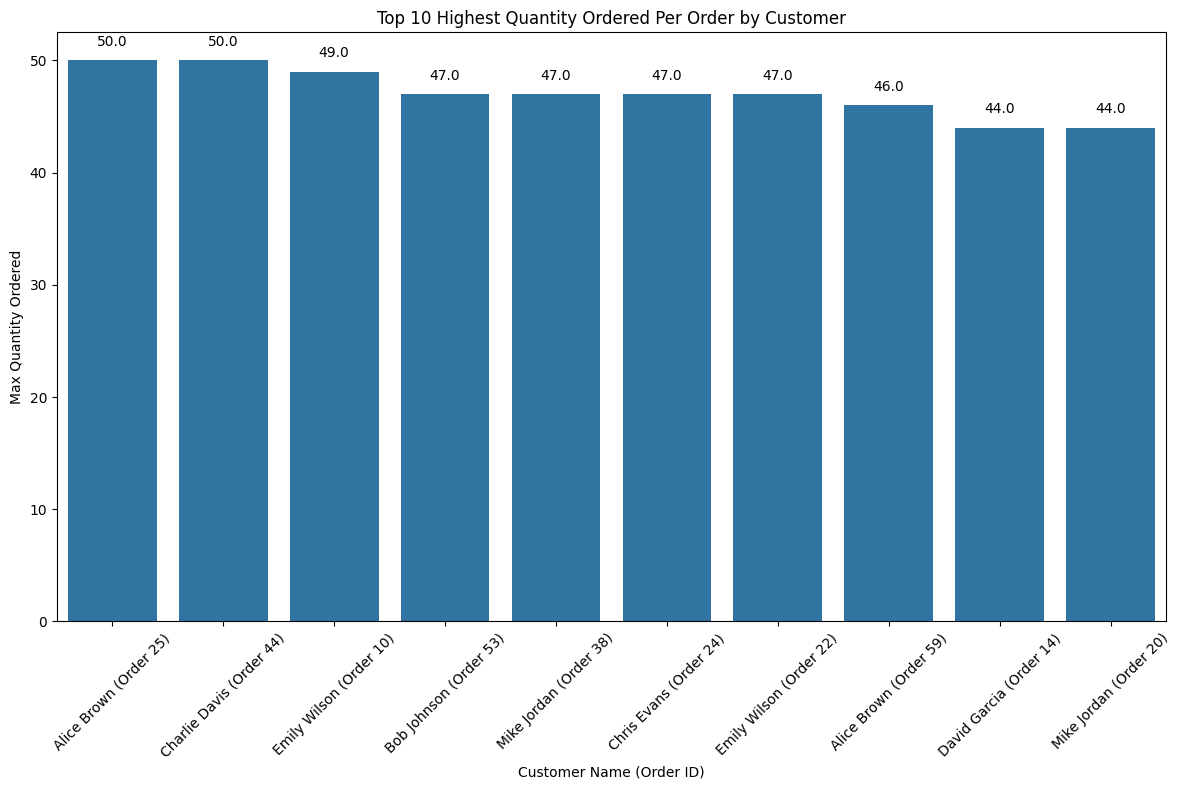

In [39]:
# Create a new column that combines 'CustomerName' and 'OrderID' for unique labels
top_10_quantities['CustomerOrder'] = top_10_quantities['Name'] + " (Order " + top_10_quantities.index.astype(str) + ")"


plt.figure(figsize=(12, 8))
sns.barplot(x='CustomerOrder', y='MAX(OrderDetails.Quantity)', data=top_10_quantities)
plt.title("Top 10 Highest Quantity Ordered Per Order by Customer")
plt.xlabel("Customer Name (Order ID)")
plt.ylabel("Max Quantity Ordered")

# Adding exact quantity values on top of each bar
for index, value in enumerate(top_10_quantities['MAX(OrderDetails.Quantity)']):
    plt.text(index, value + 1, round(value, 2), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Highest Revenue Orders (Make by customer)

In [45]:
#Aggregate to get total revenue per OrderID and Customer (Name)
top_revenue_orders = merged_data.groupby(['OrderID', 'Name'])['SUM(OrderDetails.TotalPrice)'].sum().reset_index()
# Sort by revenue in descending order and select the top 10
top_revenue_orders = top_revenue_orders.sort_values(by='SUM(OrderDetails.TotalPrice)', ascending=False).head(10)
print("Highest Revenue Per Order:")
print(top_revenue_orders)

Highest Revenue Per Order:
    OrderID           Name  SUM(OrderDetails.TotalPrice)
42      343    Alice Brown                       65550.0
52      353   Emily Wilson                       56000.0
33      334    Bob Johnson                       54700.0
12      313    Chris Evans                       47000.0
13      314    Alice Brown                       44800.0
48      349   David Garcia                       42300.0
54      355   David Garcia                       41950.0
50      351  Charlie Davis                       37800.0
19      320    Bob Johnson                       37500.0
45      346   David Garcia                       36100.0


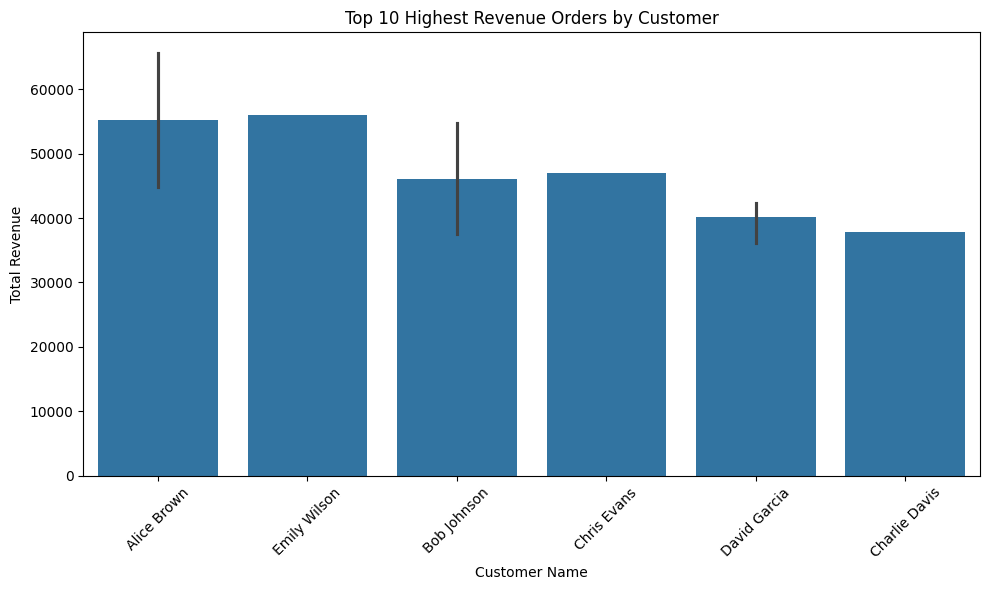

In [46]:
# Step 1: Aggregate to get total revenue per OrderID and Name (customer)
top_revenue_orders = merged_data.groupby(['OrderID', 'Name'])['SUM(OrderDetails.TotalPrice)'].sum().reset_index()

# Step 2: Sort by revenue in descending order and select the top 10
top_revenue_orders = top_revenue_orders.sort_values(by='SUM(OrderDetails.TotalPrice)', ascending=False).head(10)

# Step 3: Plotting, ensuring all rows are shown
plt.figure(figsize=(10, 6))
sns.barplot(x='Name', y='SUM(OrderDetails.TotalPrice)', data=top_revenue_orders)
plt.title("Top 10 Highest Revenue Orders by Customer")
plt.xlabel("Customer Name")
plt.ylabel("Total Revenue")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Top 10 Customers by Number of Orders



In [ ]:
orders_per_customer = merged_data.groupby('Name')['OrderID'].count().nlargest(10)
print("Top Customers by Number of Orders:")
print(orders_per_customer)

In [ ]:
# Group by CustomerName to show the number of orders per customer
orders_per_customer = orders_with_customers.groupby('Name')['OrderID'].count().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=orders_per_customer.index, y=orders_per_customer.values, palette='Purples')
plt.title('Top 10 Customers by Number of Orders')
plt.xlabel('Customer Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

##Most Common Order Day

In [ ]:
orders_df['OrderDay'] = orders_df['OrderDate'].dt.day_name()
common_order_day = orders_df['OrderDay'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=common_order_day.index, y=common_order_day.values, palette='Set2')
plt.title('Most Common Order Day')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

##Most Common Product Category Ordered

In [ ]:
category_counts = feature_matrix["MODE(OrderDetails.Products.Category)"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Most Common Product Category Ordered")
plt.show()

In [ ]:
feature_matrix.to_csv('feature_matrix.csv', index=False)

In [ ]:

def trigger_feature_engineering():
    entitySet = ft.EntitySet(id="e-commerce_es")

    #Add DataFrame to the EntitySet
#Customers
customers_entity = entitySet.add_dataframe(
    dataframe=customers_df,  #  Dataframe containing the data.
    dataframe_name='Customers',  # Unique name to associate with this dataframe
    index='CustomerID',  # Unique identifier
    time_index='SignupDate'
)

#Products
products_entity = entitySet.add_dataframe(
    dataframe=products_df,
    dataframe_name='Products',
    index='ProductID'
)

#Orders
orders_entity = entitySet.add_dataframe(
    dataframe=orders_df,
    dataframe_name='Orders',
    index='OrderID' ,
    time_index='OrderDate',
)

#OrdersDetails
orderDetails_entity = entitySet.add_dataframe(
    dataframe=order_details_df,
    dataframe_name='OrderDetails',
    index='OrderDetailsID'
)

# Define relationships
entitySet.add_relationship(parent_dataframe_name='Customers', parent_column_name='CustomerID',
                    child_dataframe_name='Orders', child_column_name='CustomerID')

entitySet.add_relationship(parent_dataframe_name='Products', parent_column_name='ProductID',
                    child_dataframe_name='OrderDetails', child_column_name='ProductID')

entitySet.add_relationship(parent_dataframe_name='Orders', parent_column_name='OrderID',
                    child_dataframe_name='OrderDetails', child_column_name='OrderID')

# Generate features with DFS for Orders fact table
  feature_matrix, feature_defs = ft.dfs(
      entityset=entitySet,
      target_dataframe_name="Orders",
      verbose=True,
      max_depth=3,
      agg_primitives=['sum', 'mean', 'count', 'max', 'min','mode'],
      trans_primitives=['month', 'day', 'year']
  )

    print("Feature Engineering Completed!")
    print(feature_matrix.head())
    return feature_matrix

# Trigger feature engineering after receiving enough updates
feature_matrix = trigger_feature_engineering()
